# Understanding Your Customers: A Fresh Take on Analyzing Product Reviews

Aisha Al-Khaldi & Huda Joad

## Where are we in the data science pipeline?

- **Ask an interesting question**
- Get the data
- Explore the data
- Model the data
- Communicate/visualize the results

### Our Question

When customers want to express their thoughts and sentiments about a product, they usually do it through written reviews and assign a rating for their experience (in our case, a boolean of positive/negative). We would like to delve into the discussion of **the relationship between the content of the review and its assigned rating**.

We will be using Steam Web API, and try to perform a sentiment analysis on reviews to answer our question.

## Where are we in the data science pipeline?

- Ask an interesting question
- **Get the data**
- Explore the data
- Model the data
- Communicate/visualize the results

### Data Collection

In order to complete this notebook and have a deep understanding of customer reviews, we need a lot of imports! Make sure you run this so we can start our journey! Make sure to do pip installs in case you don't have these yet ⬇️!!

In [1]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 5.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# they don't bite don't worry!

import requests
import pandas as pd
import time
from requests.exceptions import ConnectionError
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import gensim.downloader as api
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from collections import Counter

# Some NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

/Users/awashi/miniconda3/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (None)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/awashi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/awashi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Steam API

Steam has a web API. This means we don't actually need an API key to extract what we need, which are the reviews for various games. Instead, we can simply use different URLs.

*More about Steam's web API can be found [here](https://partner.steamgames.com/doc/store/getreviews).*

The web API allows us to filter by positive and negative reviews, which means we can use this to get labeled data without having to do it ourselves. Currently, there are over 1.6 million apps, although all of them do not necessarily have reviews.

(We also tried using Steam's regular API but we found that it was very complicated to use and you needed to have things published already to use it. After that we also tried using the `steamreviews` python library but it was broken unfortunately. In total, data collection took us 11 days to finalize.)

In [2]:
# This is an example to showcase what scraping the Web API gives

url = "https://store.steampowered.com/appreviews/50?json=1&review_type=negative"
r = requests.get(url)
data = r.json()
data

{'success': 1,
 'query_summary': {'num_reviews': 3},
 'reviews': [{'recommendationid': '150455924',
   'author': {'steamid': '76561198053624818',
    'num_games_owned': 0,
    'num_reviews': 156,
    'playtime_forever': 357,
    'playtime_last_two_weeks': 357,
    'playtime_at_review': 357,
    'last_played': 1700459686},
   'language': 'english',
   'review': "The gameplay is great, but not as tight as Half Life. Considering Randy Pitchford made it, Opposing Force is surprisingly competent. Though the last few hours feel like blatant filler, and the boss fight is the biggest waste of time (easily the worst boss in all of the HL series).\n\nThe new weapons are welcome, but the squad concept is half-baked. Other than occasionally healing you, they are there solely to trigger scripted events. The rope physics are utterly broken, but that might just be a consequence of running this over 30 fps. The major problem is that the night-vision filter is the same color as the reticle and the weap

In this example we can see we get 2 negative reviews in JSON format. To get the reviews alone, we would use the following syntax.

In [3]:
[print(review['review']) for review in data['reviews']]

The gameplay is great, but not as tight as Half Life. Considering Randy Pitchford made it, Opposing Force is surprisingly competent. Though the last few hours feel like blatant filler, and the boss fight is the biggest waste of time (easily the worst boss in all of the HL series).

The new weapons are welcome, but the squad concept is half-baked. Other than occasionally healing you, they are there solely to trigger scripted events. The rope physics are utterly broken, but that might just be a consequence of running this over 30 fps. The major problem is that the night-vision filter is the same color as the reticle and the weapon selection menu, so in the dark you not only can't aim, but you also can't see what weapon you are switching to, and this game has a lot of dark spaces. Gearbox didn't do basic QA testing evidently.

Unfortunately, the updated Steam version with widescreen support is broken as of writing, so the game may freeze or crash without warning. I think my save files mig

[None, None, None]

We would know that these are negative reviews as we filtered for negative reviews in the URL for the Steam web API. With all this information, we can now programatically get labeled reviews. For the sake of this project, **we will simply a minimum of the first 5,000 positive and negative reviews and go through the apps in order starting from app ID 1.**

### 🚨⚠️ 𝐃𝐨 𝐧𝐨𝐭 𝐫𝐮𝐧 𝐭𝐡𝐞 𝐜𝐞𝐥𝐥 𝐛𝐞𝐥𝐨𝐰. 𝐖𝐞 𝐡𝐚𝐯𝐞 𝐭𝐡𝐢𝐬 𝐛𝐥𝐨𝐜𝐤 𝐨𝐟 𝐜𝐨𝐝𝐞 𝐭𝐨 𝐠𝐞𝐧𝐞𝐫𝐚𝐭𝐞 𝐭𝐡𝐞 𝐜𝐬𝐯 𝐟𝐢𝐥𝐞𝐬 𝐟𝐨𝐫 𝐲𝐨𝐮! 𝐔𝐧𝐥𝐞𝐬𝐬 𝐲𝐨𝐮 𝐡𝐚𝐯𝐞 𝟔+ 𝐡𝐨𝐮𝐫𝐬 𝐭𝐨 𝐬𝐩𝐚𝐫𝐞, 𝐲𝐨𝐮 𝐜𝐚𝐧 𝐬𝐤𝐢𝐩 𝐭𝐡𝐢𝐬 𝐜𝐞𝐥𝐥 𝐚𝐧𝐝 𝐟𝐨𝐥𝐥𝐨𝐰 𝐚𝐥𝐨𝐧𝐠 𝐰𝐢𝐭𝐡 𝐭𝐡𝐞 𝐜𝐬𝐯 𝐟𝐢𝐥𝐞 𝐰𝐞 𝐚𝐥𝐫𝐞𝐚𝐝𝐲 𝐩𝐫𝐨𝐯𝐢𝐝𝐞𝐝 𝐟𝐨𝐫 𝐲𝐨𝐮! ⚠️🚨

In [ ]:
# Function to fetch reviews from Steam API for a given game ID and review type (positive or negative)
def fetch_reviews(game_id, review_type):
    url = f"https://store.steampowered.com/appreviews/{game_id}?json=1&review_type={review_type}"
    try:
        r = requests.get(url)  # Make an HTTP GET request to the API
        if r.status_code == 200:
            data = r.json()  # Parse the JSON response
            return [review['review'] for review in data['reviews']]  # Return a list of reviews
    except ConnectionError:
        print(f"Connection error for game ID {game_id}. Retrying...")
        time.sleep(5)  # Wait for 5 seconds before retrying. Without this you'll crash after running for 3+ hours...
        return fetch_reviews(game_id, review_type)  # Recursive retry
    return []  # Return an empty list if the request fails or an exception occurs :()

# Initialize lists to store positive and negative reviews
positive_reviews = []
negative_reviews = []
game_id = 1  # Start from the first game ID

# Loop until you get 5000 positive and 5000 negative reviews
while len(positive_reviews) < 5000 or len(negative_reviews) < 5000:
    print(f"Game ID: {game_id}")
    if len(positive_reviews) < 5000:
        # Fetch and add positive reviews for the current game ID
        positive_reviews.extend(fetch_reviews(game_id, 'positive'))
        print(f"    Total Positive Reviews: {len(positive_reviews)}")

    if len(negative_reviews) < 5000:
        # Fetch and add negative reviews for the current game ID
        negative_reviews.extend(fetch_reviews(game_id, 'negative'))
        print(f"    Total Negative Reviews: {len(negative_reviews)}")

    game_id += 1  # Increment the game ID for the next iteration
    time.sleep(0.2)  # Pause for 0.5 seconds to avoid hitting the rate limit!!

# Combine the positive and negative reviews into a single list with their corresponding sentiment labels
reviews_data = [(review, 'positive') for review in positive_reviews] + \
               [(review, 'negative') for review in negative_reviews]

# Create a DataFrame from the combined review data
df = pd.DataFrame(reviews_data, columns=['review', 'sentiment'])

# Save the DataFrame to a CSV file, without the index and using UTF-8 encoding
# This way you don't have to run this code for 6+ hours :D
df.to_csv('steam_reviews.csv', index=False, encoding='utf-8')

Let's start, shall we! First we will be creating a dataframe for the reviews!

In [4]:
reviews_df = pd.read_csv('steam_reviews.csv', encoding='utf-8') # Read the CSV we generated!

In [5]:
reviews_df

,review,sentiment
0,if ur tired of cs2 come back to 2000 and play ...,positive
1,Counter-Strike 1.6 was a significant part of m...,positive
2,rather pay for this than winrar,positive
3,Better then CS2,positive
4,"Every school that i have attended, had this in...",positive
...,...,...
9998,Its just a terrible clone of katamari. And IMO...,negative
9999,TL:DR this game was made 12 year old who got a...,negative
10000,Insultingly bad Katamari Damacy rip-off.,negative
10001,The poor man's Katamari Damacy.,negative


In [6]:
reviews_df.sentiment.value_counts()

negative    5003
positive    5000
Name: sentiment, dtype: int64

Now we have 10,003 total reviews from 15,970 apps, split almost evenly between 5,003 negative and 5,000 positive reviews. Having the same amount of data for each type of review, negative and positive, is really important because the balance means that our model won't lean more towards one sentiment over the other. Our model will learn to recognize both positive and negative comments equally, which helps it make fair and accurate predictions.

## Where are we in the data science pipeline?

- Ask an interesting question
- Get the data
- **Explore the data**
- Model the data
- Communicate/visualize the results

### Data Processing

Before we dive into the world of sentiment analysis, we first have to process our data using our API. 

In [7]:
reviews_df.isna().sum()

review       5
sentiment    0
dtype: int64

Since we have enough reviews, we can simply drop the rows with null values.

In [8]:
reviews_df.dropna(inplace=True)
reviews_df.isna().sum()

review       0
sentiment    0
dtype: int64

In [9]:
reviews_df.shape

(9998, 2)

### Exploration/Visualization

The next step in our journey is to visualize what we have obtained from the dataframe, we do this by generating a bar plot using Seaborn to clearly distinguish the positive and negative reviews with different colors and extra annotations!

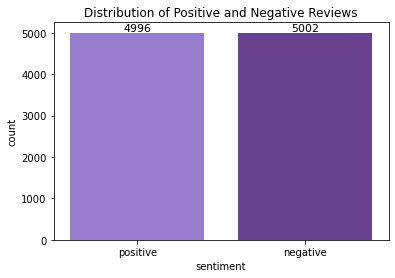

In [10]:
# The distribution of sentiments in the dataset
palette = {"positive": "#9370db", "negative": "#69359c"}
plot = sns.countplot(data=reviews_df, x='sentiment', palette=palette)
plt.title('Distribution of Positive and Negative Reviews')

# Using annotations to showcase the exact difference between the two review features
for bar in plot.patches:
    plot.annotate(f'{bar.get_height()}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

As you can see in the above plot, we found an almost equal number of positive and negative comments: 4,996 positive and 5,002 negative (we provided annotations on the graph for extra clarification due to the small difference between the two). We now understand that customers are just as likely to share positive comments as they are to share negative ones.

## Where are we in the data science pipeline?

- Ask an interesting question
- Get the data
- Explore the data
- **Model the data**
- Communicate/visualize the results

The model we will be using is a Random Forest Classifier. A random forest classifier can capture more complex relationships between words and sentiment. It's a good choice when you want to explore a slightly more advanced model without diving too deep into complex algorithms.

### Analysis/Machine Learning

In order to model the data, first we want to tokenize it, similar to what we did in a previous assignment in this course. Think of a very complex Lego set you've seen, we want to dismantle this set and train our model with each individual brick – this is tokenization. By doing so, our model can create it's own Lego set!

#### Text Preprocessing

With text preprocessing, we are cleaning our individual bricks (data) so we can effectively train our model!

In [11]:
# Creating a new dataframe
reviews_preprocessed_df = reviews_df.copy()
reviews_preprocessed_df

,review,sentiment
0,if ur tired of cs2 come back to 2000 and play ...,positive
1,Counter-Strike 1.6 was a significant part of m...,positive
2,rather pay for this than winrar,positive
3,Better then CS2,positive
4,"Every school that i have attended, had this in...",positive
...,...,...
9998,Its just a terrible clone of katamari. And IMO...,negative
9999,TL:DR this game was made 12 year old who got a...,negative
10000,Insultingly bad Katamari Damacy rip-off.,negative
10001,The poor man's Katamari Damacy.,negative


In [12]:
def preprocess_text(text):
    text = text.lower() # Lowercasing
    text = re.sub('[^a-zA-Z]', ' ', text) # Remove punctuations and numbers
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # Remove single character words
    text = re.sub(r'\s+', ' ', text) # Remove multiple spaces

    words = text.split() # Tokenization

    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    
    return ' '.join(words) # The reason we join here is to use TfidfVectorizer later

# Apply preprocessing to each review
reviews_preprocessed_df['review'] = reviews_df['review'].apply(preprocess_text)

We just want to show, by running the below code, the comparison between the original and preprocessed reviews:

In [13]:
print(reviews_df.review.head())
print()
print(reviews_preprocessed_df.review.head())

0    if ur tired of cs2 come back to 2000 and play ...
1    Counter-Strike 1.6 was a significant part of m...
2                      rather pay for this than winrar
3                                      Better then CS2
4    Every school that i have attended, had this in...
Name: review, dtype: object

0                          ur tired c come back play c
1    counter strike significant part childhood firs...
2                                    rather pay winrar
3                                             better c
4       every school attended installed every computer
Name: review, dtype: object


As you can see from the results, the first set of reviews includes causal language, spelling and grammar. After this set of reviews pass our preprocessing function you can see that it has cleaned up the words by resorting the words to their base form. This is important to our journey as it provides our model with a clean set of reviews to train from and to aid us in figuring out the overall sentiment.

In [14]:
# Total words

# Create a list of all words in the preprocessed reviews
all_words = ' '.join(reviews_preprocessed_df['review']).split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Get the number of unique words
num_unique_words = len(word_counts)

# Print the number of unique words
print(f'Number of unique words: {num_unique_words}')

# Optionally, if you want to see the top 20 most common words as well
# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Print the top 20 words and their counts
for word, count in top_20_words:
    print(f'{word}: {count}')

Number of unique words: 23568
game: 20068
like: 4192
one: 3410
get: 3384
time: 3245
play: 3193
good: 2681
even: 2504
really: 2241
fun: 1987
make: 1843
first: 1761
level: 1734
would: 1724
also: 1636
still: 1631
much: 1613
story: 1556
work: 1486
well: 1448


#### Feature Extraction

In order to complete the feature extraction, we will start by creating a TF-IDF vectorizer to then split the data!

In [15]:
# Creating a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(reviews_preprocessed_df['review']).toarray()

#### Split the data

In [16]:
y = reviews_preprocessed_df['sentiment'].map({'positive': 1, 'negative': 0}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # train_test_split is our favorite function

### Training Set Labels Distribution

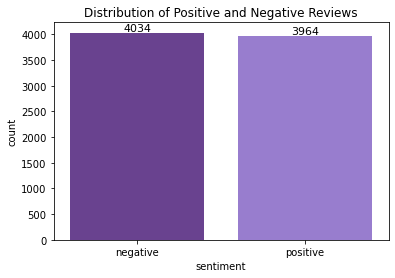

In [17]:
# Convert y_train to a DataFrame and map back to 'positive' and 'negative'
y_train_df = pd.DataFrame(y_train, columns=['sentiment'])
y_train_df['sentiment'] = y_train_df['sentiment'].map({1: 'positive', 0: 'negative'})

# Define the color palette
palette = {"positive": "#9370db", "negative": "#69359c"}

# Create the count plot
plot = sns.countplot(data=y_train_df, x='sentiment', palette=palette)
plt.title('Distribution of Positive and Negative Reviews')

# Annotate the bars with the exact counts
for bar in plot.patches:
    plot.annotate(f'{bar.get_height()}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                  ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                  textcoords='offset points')

plt.show()

### Test Set Labels Distribution

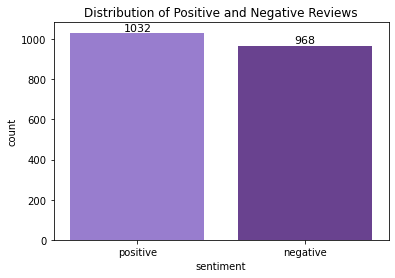

In [18]:
# Convert y_train to a DataFrame and map back to 'positive' and 'negative'
y_test_df = pd.DataFrame(y_test, columns=['sentiment'])
y_test_df['sentiment'] = y_test_df['sentiment'].map({1: 'positive', 0: 'negative'})

# Define the color palette
palette = {"positive": "#9370db", "negative": "#69359c"}

# Create the count plot
plot = sns.countplot(data=y_test_df, x='sentiment', palette=palette)
plt.title('Distribution of Positive and Negative Reviews')

# Annotate the bars with the exact counts
for bar in plot.patches:
    plot.annotate(f'{bar.get_height()}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                  ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                  textcoords='offset points')

plt.show()

We decided to showcase both the test and training sets label distribution because having even number of labels for the training makes the classifier not biased. In addition, having equal number for testing makes the result metrics fairer.

#### Train the Random Forest classifier

We begin by initializing the Random Forest Classifier with an arbritary n_estimators, which we will get into futher down the notebook! Then, we start training the model!

In [19]:
# Initializing the Random Forest Classifier with an arbritary n_estimators (we'll get into that later...)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Where are we in the data science pipeline?

- Ask an interesting question
- Get the data
- Explore the data
- Model the data
- **Communicate/visualize the results**

#### Evaluate the model

Great job, we have reached the end of the rainbow! It's time to evaluate the model! We begin with this step by initializing the y_pred, which predicts the test set results, et voilá! Time to evaluate!

In [20]:
# Predicting the test set results
y_pred = rf_classifier.predict(X_test)

# Evaluating the results
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7765
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       968
           1       0.80      0.76      0.78      1032

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



#### Try using the model to predict the sentiment of new reviews

In [21]:
def predict_sentiment(review):
    review = preprocess_text(review)
    review_vector = tfidf_vectorizer.transform([review]).toarray()
    prediction = rf_classifier.predict(review_vector)
    return 'positive' if prediction[0] == 1 else 'negative'

# Providing an example
print(predict_sentiment("This is a great product!"))

positive


As you can see with the predict_sentiment function, our model has predicted correctly with the test review!

### Insights

### Confusion Matrix:

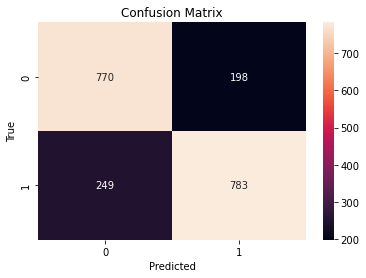

In [22]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='rocket')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

As you can see from the above matrix, we can determine the true positives, true negatives, false positives and false negatives of our model compared to the actual classifications. The model predicted 783 positive instances (true positives [1,1]). The model predicted 770 negative instances (true negatives [0,0]), 198 incorrect predictions at the top right (false positives [0,1]) and 249 incorrect predictions of positive instances (false negatives [1,0]). From these observations, we can see that the model has a balanced prediction ability.

### Feature Importances

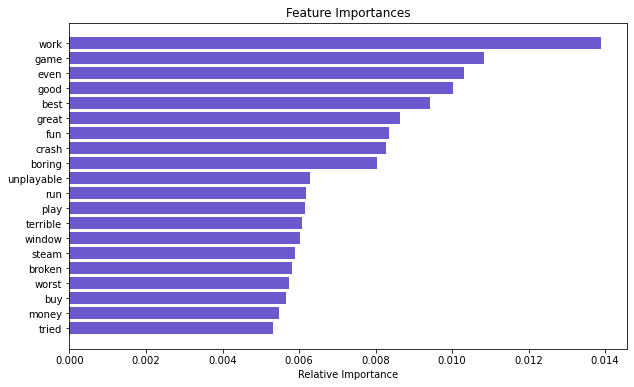

In [24]:
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#6a5acd', align='center')
# If you face an AttributeError, replace [tfidf_vectorizer.get_feature_names_out()[i] for i in indices]
# with [tfidf_vectorizer.get_feature_names()[i] for i in indices]
plt.yticks(range(len(indices)), [tfidf_vectorizer.get_feature_names_out()[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The above chart showcases the feature importance and how our model identifies certain words as hints for whether the review is positive or negative. You can see words like "work," "good" and "best" are highly influential to the model's consideration process. Positive sentiments include "good," "best" and "fun". Negative sentiments include "worst", "broken", "unplayable", and "terrible".

### Precision Recall Curve

In [25]:
y_scores = rf_classifier.predict_proba(X_test)[:, 1]

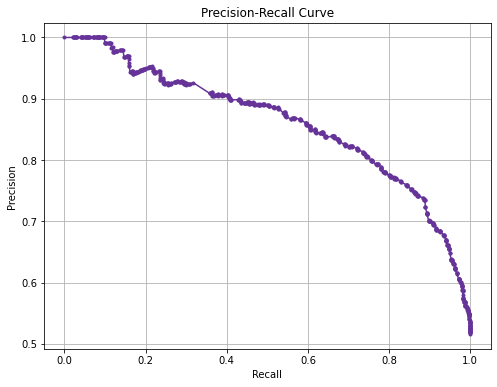

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='#663399')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [28]:
auc_score = auc(recall, precision)
print(f'Precision-Recall AUC: {auc_score}')

Precision-Recall AUC: 0.8611403552026985


As you can see from the precision-recall curve, the model is classifying the true positives, the precision is communicating how accurate the model's predictions are and recall tells us the true positives. The curve depicts that the model is keeping the recall low by being extremely picky. In addition, the precision is high. However, it tries to catch as many positives as possible and increasing the recall. This is not good because the model is more prone to making mistakes and the precision will go down. The model is essentially keeping it fair between obtaining all positives and maintaining precision. 

TF-IDF Analysis

The reason why we decided to use the TF-IDF Analysis is what makes each word have their designated importance as a numerical value!

In [29]:
# Creating different dataframes for the respective reviews
positive_reviews_df = reviews_df[reviews_df['sentiment'] == 'positive']
negative_reviews_df = reviews_df[reviews_df['sentiment'] == 'negative']

# Transforming the reviews into TF-IDF features
positive_tfidf_matrix = tfidf_vectorizer.transform(positive_reviews_df['review']).toarray()
negative_tfidf_matrix = tfidf_vectorizer.transform(negative_reviews_df['review']).toarray()

In [30]:
# Calculating the average TF-IDF scores
avg_tfidf_positive = np.mean(positive_tfidf_matrix, axis=0)
avg_tfidf_negative = np.mean(negative_tfidf_matrix, axis=0)

In [32]:
# Getting the feature names
# If you face an AttributeError, replace tfidf_vectorizer.get_feature_names_out()
# with [tfidf_vectorizer.get_feature_names()
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sorting the indices of the TF-IDF scores
sorted_positive_indices = np.argsort(avg_tfidf_positive)[::-1]
sorted_negative_indices = np.argsort(avg_tfidf_negative)[::-1]

# Finding the top terms in both the positive and negative reviews
print("Top terms in positive reviews:")
for i in sorted_positive_indices[:10]:
    print(f"{feature_names[i]}: {avg_tfidf_positive[i]}")

print("\nTop terms in negative reviews:")
for i in sorted_negative_indices[:10]:
    print(f"{feature_names[i]}: {avg_tfidf_negative[i]}")


Top terms in positive reviews:
game: 0.07436885852133364
as: 0.05927224214685998
good: 0.039489995925651444
there: 0.03447157572271128
fun: 0.028644328905778123
great: 0.02632767278246613
like: 0.025639696303926724
best: 0.021592084487601228
play: 0.021199692048634936
do: 0.021073910594984188

Top terms in negative reviews:
game: 0.0791084135956513
as: 0.06106434822907185
there: 0.0522452436401279
do: 0.04397467186592111
play: 0.02714395597435466
work: 0.02550148633835049
like: 0.024885166575956033
even: 0.023014570326775115
get: 0.02263206268260621
over: 0.019992288415743555


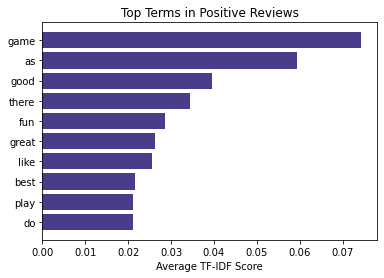

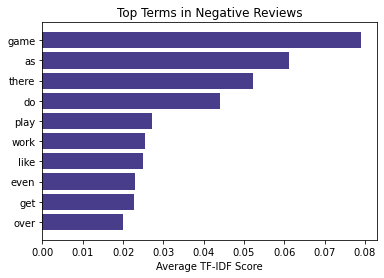

In [33]:
def top_terms(indices, scores, title, num_terms=10, color='#483d8b'):
    terms = [feature_names[i] for i in indices[:num_terms]]
    scores = [scores[i] for i in indices[:num_terms]]
    plt.barh(terms, scores, color=color)
    plt.xlabel('Average TF-IDF Score')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Plotting the top terms in both positive and negative reviews
top_terms(sorted_positive_indices, avg_tfidf_positive, 'Top Terms in Positive Reviews')
top_terms(sorted_negative_indices, avg_tfidf_negative, 'Top Terms in Negative Reviews')


## Improving the model

### 🚨⚠️ 𝐃𝐨𝐧'𝐭 𝐫𝐮𝐧, 𝐮𝐧𝐥𝐞𝐬𝐬 𝐲𝐨𝐮 𝐡𝐚𝐯𝐞 𝟒+ 𝐡𝐨𝐮𝐫𝐬 𝐭𝐨 𝐬𝐩𝐚𝐫𝐞! ⚠️🚨

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define the parameter grid
param_grid = {
    'tfidf__max_features': [2000, 3000, 4000, 5000, 6000],  # Different max_features for TfidfVectorizer
    'rf__n_estimators': [100, 200, 300, 400, 500]     # Different n_estimators for RandomForestClassifier
}

# Define the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(accuracy_score), cv=3, verbose=2)

# Apply the same preprocessing to 'review' and map 'sentiment' as before
# X is just the raw text data (list of reviews) and y is the mapped sentiment
X = reviews_preprocessed_df['review']
y = reviews_preprocessed_df['sentiment'].map({'positive': 1, 'negative': 0}).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_pipeline = grid_search.best_estimator_

# Predict using the best model
y_pred_best = best_pipeline.predict(X_test)

# Evaluate the model
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print(f"Best Model Accuracy: {accuracy_best}")
print(f"Classification report of the best model:\n{report_best}")
print(f"Best Model Parameters: {grid_search.best_params_}")

The best model accuracy we got is using 'max_features': 6000, and 'n_estimators': 400. Now we can build a model and test it using these features to compare to our last model.

In [34]:
# Assuming reviews_preprocessed_df is your preprocessed DataFrame with 'review' and 'sentiment' columns
# 'review' contains the preprocessed text, and 'sentiment' is the target variable

# Creating a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=6000)
X = tfidf_vectorizer.fit_transform(reviews_preprocessed_df['review']).toarray()

# Map 'positive' and 'negative' to 1 and 0
y = reviews_preprocessed_df['sentiment'].map({'positive': 1, 'negative': 0}).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(n_estimators=400, random_state=42)

# Fit the model to the training data
rf_best.fit(X_train, y_train)

# Predict using the model
y_pred_best = rf_best.predict(X_test)

# Evaluate the model
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print(f"Accuracy of the best model: {accuracy_best}")
print(f"Classification report of the best model:\n{report_best}")

Accuracy of the best model: 0.785
Classification report of the best model:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       968
           1       0.81      0.76      0.79      1032

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.78      2000
weighted avg       0.79      0.79      0.79      2000



From the results provided, we can conclude that the F1 score went up by 1%. However, we don't know whether this improvement is significant yet.

In [35]:
y_scores = rf_best.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
print(f'Precision-Recall AUC: {auc_score}')

Precision-Recall AUC: 0.8657842151563565


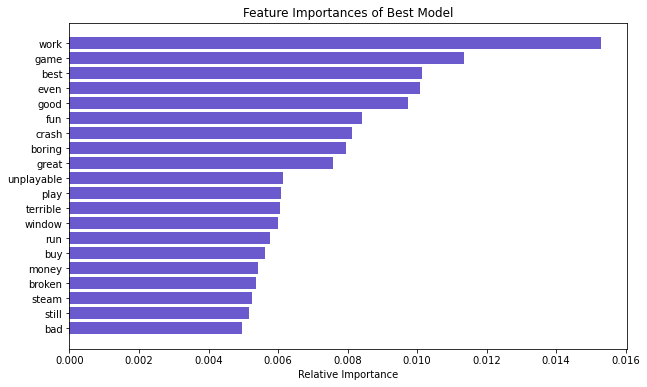

In [36]:
importances = rf_best.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.title('Feature Importances of Best Model')
plt.barh(range(len(indices)), importances[indices], color='#6a5acd', align='center')
# if you are faced with an error, replace [tfidf_vectorizer.get_feature_names_out()[i] for i in indices]
# with [tfidf_vectorizer.get_feature_names()[i] for i in indices]
plt.yticks(range(len(indices)), [tfidf_vectorizer.get_feature_names_out()[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The words in the graph are the results of the model which displays the words with the most importance. 

### Using word embeddings

#### Load Pre-trained Word Embeddings:

In [37]:
# Load the pre-trained Word2Vec model (this takes some time)
word2vec_model = api.load('word2vec-google-news-300')  # This is a large model!

#### Convert reviews to vectors

In [38]:
def review_to_vector(review, model):
    # Tokenize the review and filter out words not in the Word2Vec vocabulary
    words = [word for word in review.split() if word in model.key_to_index]

    # If the review contains no words in the Word2Vec vocabulary, return a zero vector
    if len(words) == 0:
        return np.zeros(model.vector_size)

    # Compute the average Word2Vec for the words in the review
    review_vector = np.mean([model[word] for word in words], axis=0)
    return review_vector

# Load the pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

# Apply the function to each review in the DataFrame
X = np.array([review_to_vector(review, word2vec_model) for review in reviews_preprocessed_df['review']])

#### Train the classifier with the vectors

In [39]:
# Map 'positive' and 'negative' to 1 and 0
y = reviews_preprocessed_df['sentiment'].map({'positive': 1, 'negative': 0}).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=400, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf_classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.778
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       968
           1       0.78      0.78      0.78      1032

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



In [40]:
y_scores = rf_classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
print(f'Precision-Recall AUC: {auc_score}')

Precision-Recall AUC: 0.856047419956063


#### If we do it on regular reviews_df

In [41]:
# Apply the function to each review in the DataFrame
X = np.array([review_to_vector(review, word2vec_model) for review in reviews_df['review']])

# Map 'positive' and 'negative' to 1 and 0
y = reviews_df['sentiment'].map({'positive': 1, 'negative': 0}).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf_classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7455
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       968
           1       0.76      0.74      0.75      1032

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



In [42]:
y_scores = rf_classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
print(f'Precision-Recall AUC: {auc_score}')

Precision-Recall AUC: 0.8409910031026868


We can see that the model using the raw data is 4% worse than the model using the clean data. We understand the difference between using raw and clean data should be substantial, so the 1% increase from the first to the second model is a decent result when considering this.

In [44]:
def predict_sentiment(review):
    review = preprocess_text(review)
    review_vector = tfidf_vectorizer.transform([review]).toarray()
    prediction = rf_best.predict(review_vector)
    return 'positive' if prediction[0] == 1 else 'negative'

# Providing an example
print(predict_sentiment("this is so bad"))

negative


## Findings and Conclusion

We originally, after analysing the data, found the following:
- We read through the data and found that some reviews were sarcastic and the API labeled them incorrectly, which is not beneficial for training (e.g. yes)
- A lot of reviews were weird that didn’t have any meaning (like just letters and punctuation without meaning, e.g. á-á-á-á-á-á-á-á-á-á)
- Not all the reviews had criticisms about the game (e.g. JUMPING THROUGH POTRALS WEEEE)
- Some reviews were random and didn’t really match a certain sentiment

To resolve these issues, we did the following:
- We used Random Forest Classifier to find the 6,000 words with the most importance in discriminating between positive and negative reviews, and then would classify a review based on the feature (word) importances it found.
